In [232]:
import pandas as pd
import matplotlib.pyplot as pl
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Attention,Embedding,Dense,Input,Flatten,Concatenate,Dropout,Conv1D,GlobalMaxPool1D,BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD,Adam
from tqdm import tqdm

# Pull Gravity database

In [218]:
import functions as fn
grav_domains = fn.load_gravity(dir='').domain.values
grav_df = pd.DataFrame({'domain':grav_domains,'blocked':np.ones(len(grav_domains))})

# Pull PiHole DNS Data

In [222]:
from sqlalchemy import create_engine

db_connect = create_engine('sqlite:///pihole-FTL.db')
connection = db_connect.raw_connection()
df = pd.read_sql("SELECT * FROM queries", con=connection)
df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)           # 2,3 are domains blocked by gravity and
                                                                            # blacklist
df = pd.concat([df,grav_df]).reset_index()
#df.domain = df.domain.apply(lambda x: x.replace('.',' ').replace('-',' ')) # Model performs better leaving DNS
                                                                            # names as is

np.savetxt('domains.txt',df.domain.values,fmt="%s")
print(df.domain.head())

0    mobile.pipe.aria.microsoft.com
1    mobile.pipe.aria.microsoft.com
2             telemetry.dropbox.com
3                    login.live.com
4                    edge.skype.com
Name: domain, dtype: object


# Train/Load Tokenization Model

In [5]:
import random
import youtokentome as yttm

train_data_path = "domains.txt"
model_path = "./yttm_model/yttm_ads.model"

# Training model
yttm.BPE.train(data=train_data_path, vocab_size=300, model=model_path)

# Loading model
bpe = yttm.BPE(model=model_path)

# Two types of tokenization
print(bpe.encode(list(' '.join(df.domain.values[0].split('.'))), output_type=yttm.OutputType.ID))
print(bpe.encode(list(df.domain.values[0]), output_type=yttm.OutputType.SUBWORD))
print(' '.join(df.domain.values[0].split('.')))

[[95], [150], [114], [286], [212], [171], [], [93], [286], [93], [171], [], [165], [4, 15], [286], [165], [], [95], [286], [104], [4, 15], [150], [80], [150], [184], [130], [], [104], [150], [95]]
[['▁m'], ['▁o'], ['▁b'], ['▁i'], ['▁l'], ['▁e'], ['▁', '.'], ['▁p'], ['▁i'], ['▁p'], ['▁e'], ['▁', '.'], ['▁a'], ['▁', 'r'], ['▁i'], ['▁a'], ['▁', '.'], ['▁m'], ['▁i'], ['▁c'], ['▁', 'r'], ['▁o'], ['▁s'], ['▁o'], ['▁f'], ['▁t'], ['▁', '.'], ['▁c'], ['▁o'], ['▁m']]
mobile pipe aria microsoft com


# Siamese Model with triplet loss/metric learning

In [225]:
def build_siamese():
    
    def base_model():
        query_input = Input(shape=(30,))
        token_embedding = tf.keras.layers.Embedding(input_dim=301, output_dim=64)
        query_embeddings = token_embedding(query_input)
        qdense1 = Dense(32,activation='relu')(Flatten()(query_embeddings))
        qdense2 = Dense(32,activation='relu')(qdense1)
        qdense3 = Dense(32,activation=None)(qdense2)
        return Model(inputs=query_input,outputs=qdense3)
    
    def metric():
        inputs = Input(shape=(64,))
        d1 = Dense(64,activation='relu')(inputs)
        d2 = Dense(64,activation='relu')(d1)
        d3 = Dense(2,activation='softmax')(d2)
        return Model(inputs=inputs,outputs=d3)
    
    def triplet_loss(true,pred):
        M1 = 1.
        M2 = .0
        loss = tf.reduce_mean(tf.maximum(pred[:,0]**2 - pred[:,1]**2 + M1,0))
        return loss
    
    def custom_acc(true,pred):
        print(pred.get_shape().as_list())
        pred_ad_1 = tf.cast(tf.where(pred[:,0] < pred[:,1] ,1,0),tf.int16)
        total = tf.keras.backend.sum(tf.cast(pred_ad_1,tf.float32))
        return total/tf.cast(tf.size(pred_ad_1),tf.float32)
    
    input_pos = Input(shape=(30,))
    input_neg = Input(shape=(30,))
    input_anchor_1 = Input(shape=(30,))
    
    ad_model = attention_model()
    metric_model = metric()
    
    pos = ad_model(input_pos)
    anchor_pos = ad_model(input_anchor_1)
    neg = ad_model(input_neg)
    
    AP = metric_model(Concatenate(axis=-1)([pos,anchor_pos]))
    AN = metric_model(Concatenate(axis=-1)([neg,anchor_pos]))
    
    distances = tf.keras.layers.concatenate([AP[:,:1],AN[:,:1]],axis=1)
    
    metric_m = Model(inputs=[input_pos,input_neg,input_anchor_1],outputs=distances)
    metric_m.compile(optimizer=SGD(learning_rate=1e-2),loss=quadruple_loss,metrics=[custom_acc])
    return metric_m

In [228]:
class model_wrapper():
    def __init__(self,ml_model,tok_model):
        self.ml_model = ml_model
        self.tok_model = tok_model
    def predict(self,x,y,z):
        encoded_x = pad_sequences(self.tok_model.encode([x], output_type=yttm.OutputType.ID),30,padding='post').reshape(1,50)
        encoded_y = pad_sequences(self.tok_model.encode([y], output_type=yttm.OutputType.ID),30,padding='post').reshape(1,50)
        encoded_z = pad_sequences(self.tok_model.encode([z], output_type=yttm.OutputType.ID),30,padding='post').reshape(1,50)
        return self.ml_model.predict([encoded_x,encoded_y,encoded_z])

In [233]:
def make_query_pairs(dframe,tokenizer,sample_count=1000):
    blacklist = dframe.loc[dframe.blocked==1].reset_index()
    whitelist = dframe.loc[dframe.blocked==0].reset_index()
    bl_len = len(blacklist)
    wl_len = len(whitelist)
    samples = sample_count
    labels = np.random.choice([-1],size=samples)
    label_out = []
    pairs = []
    anchors = []
    anchors_2 = []
    for i,l in tqdm(enumerate(labels)):
        if l == -1:
            if np.random.rand() > 0.0:
                idx1 = np.random.choice(range(bl_len))
                idx2 = np.random.choice(range(wl_len))
                pairs.append((blacklist.iloc[idx1].domain,whitelist.iloc[idx2].domain))
                label_out.append(0.)
            else:
                idx1 = np.random.choice(range(wl_len))
                idx2 = np.random.choice(range(bl_len))
                pairs.append((whitelist.iloc[idx1].domain,blacklist.iloc[idx2].domain))
                label_out.append(0.)
        else:
            if np.random.randn() > 0.5:
                idx1 = np.random.choice(range(wl_len))
                idx2 = np.random.choice(range(wl_len))
                pairs.append((whitelist.iloc[idx1].domain,whitelist.iloc[idx2].domain))
                label_out.append(1.)
            else:
                idx1 = np.random.choice(range(bl_len))
                idx2 = np.random.choice(range(bl_len))
                pairs.append((blacklist.iloc[idx1].domain,blacklist.iloc[idx2].domain))
                label_out.append(1.)
        anch_idx = np.random.choice(range(bl_len))
        anchors.append(blacklist.iloc[anch_idx].domain)
        anch_idx_2 = np.random.choice(range(wl_len))
        anchors_2.append(whitelist.iloc[anch_idx_2].domain)
    ref = [i[0] for i in pairs]
    query = [i[1] for i in pairs]
    return ref,query,anchors,anchors_2


In [235]:
text_ads,text_no_ads,anchors_ads,anchors_no_ads = make_query_pairs(df,bpe,sample_count=100)

text_ads = pad_sequences(list(map(lambda x: bpe.encode(x),text_ads)),30,padding='post')
text_no_ads = pad_sequences(list(map(lambda x: bpe.encode(x),text_no_ads)),30,padding='post')
anchors_ads = pad_sequences(list(map(lambda x: bpe.encode(x),anchors_ads)),30,padding='post')
anchors_no_ads = pad_sequences(list(map(lambda x: bpe.encode(x),anchors_no_ads)),30,padding='post')

100it [00:04, 24.58it/s]


# Split into Train/Test

In [236]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(range(len(text_ads)),test_size=0.10, random_state=5)

ads_train = text_ads[train]
no_ads_train = text_no_ads[train]
anchor_ads_train = anchors_ads[train]
anchor_no_ads_train = anchors_no_ads[train]

ads_test = text_ads[test]
no_ads_test = text_no_ads[test]
anchor_ads_test = anchors_ads[test]
anchor_no_ads_test = anchors_no_ads[test]

In [254]:
dd_model = build_double_dragon() # initialize the model

[None, 2]


Train on 90 samples, validate on 10 samples
Epoch 1/100
[None, 2]
[None, 2]
90/90 [==============================] - 2s 20ms/sample - loss: 0.9998 - custom_acc: 0.5521 - val_loss: 1.0010 - val_custom_acc: 0.4375
Epoch 2/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9996 - custom_acc: 0.5000 - val_loss: 1.0010 - val_custom_acc: 0.4375
Epoch 3/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9994 - custom_acc: 0.5208 - val_loss: 1.0008 - val_custom_acc: 0.4375
Epoch 4/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9992 - custom_acc: 0.6042 - val_loss: 1.0005 - val_custom_acc: 0.7500
Epoch 5/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9990 - custom_acc: 0.6042 - val_loss: 1.0004 - val_custom_acc: 0.6875
Epoch 6/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9988 - custom_acc: 0.6458 - val_loss: 1.0003 - val_custom_acc: 0.7500
Epoch 7/100
90/90 [==============================] - 

90/90 [==============================] - 0s 2ms/sample - loss: 0.9585 - custom_acc: 0.9375 - val_loss: 0.9841 - val_custom_acc: 0.8750
Epoch 56/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9551 - custom_acc: 0.9375 - val_loss: 0.9821 - val_custom_acc: 0.8750
Epoch 57/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9511 - custom_acc: 0.9062 - val_loss: 0.9803 - val_custom_acc: 0.8750
Epoch 58/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9468 - custom_acc: 0.9479 - val_loss: 0.9781 - val_custom_acc: 0.8750
Epoch 59/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9419 - custom_acc: 0.9375 - val_loss: 0.9761 - val_custom_acc: 0.8750
Epoch 60/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9369 - custom_acc: 0.9583 - val_loss: 0.9720 - val_custom_acc: 0.8750
Epoch 61/100
90/90 [==============================] - 0s 2ms/sample - loss: 0.9309 - custom_acc: 0.9479 - val_loss: 0.9697 - 

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  2.,  3.,  1.,  2.,  3.,  4.,  3.,  7.,  7.,  8.,
        16., 10., 14.,  6.]),
 array([0.97763115, 0.9783445 , 0.9790578 , 0.97977114, 0.9804844 ,
        0.9811978 , 0.98191106, 0.9826244 , 0.98333776, 0.98405105,
        0.9847644 , 0.9854777 , 0.98619103, 0.9869043 , 0.9876177 ,
        0.98833096, 0.9890443 , 0.98975766, 0.99047095, 0.9911843 ,
        0.9918976 , 0.99261093, 0.9933242 , 0.99403757, 0.9947509 ,
        0.9954642 , 0.99617755, 0.99689084, 0.9976042 , 0.9983175 ,
        0.9990308 ], dtype=float32),
 <BarContainer object of 30 artists>)

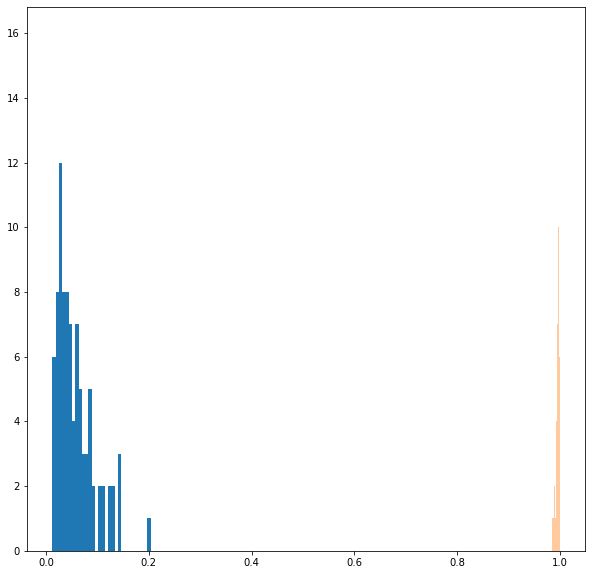

In [255]:
semi_hard_idx = (np.abs(distances[:,0]) >= 0.0)&(np.abs(distances[:,0]) <= 1.)

hist = dd_model.fit([no_ads_train[semi_hard_idx],ads_train[semi_hard_idx],anchor_no_ads_train[semi_hard_idx]],np.zeros((np.sum(semi_hard_idx),1)),epochs=100,batch_size=8,validation_data=([no_ads_test,ads_test,anchor_no_ads_test],np.zeros((len(ads_test),1))))

distances = dd_model.predict([no_ads_train,ads_train,anchor_ads_train])
pl.figure(figsize=(10,10))
pl.hist(distances[:,0],bins=30)
pl.hist(distances[:,1],bins=30,alpha=0.4)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

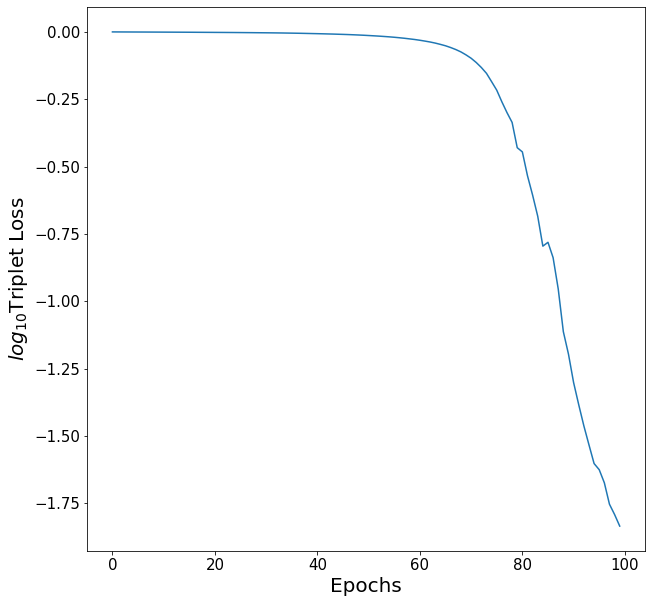

In [264]:
pl.figure(figsize=(10,10))
pl.plot(np.log10(hist.history['loss']))
pl.ylabel(r'$log_{10}$Triplet Loss',size=20)
pl.xlabel('Epochs',size=20)
pl.yticks(size=15)
pl.xticks(size=15)

# Save the Model

In [265]:
tf.keras.models.save_model(dd_model,'./models/siamese_metric_triplet_loss.h5')
# Example loading model back up with custom loss and accuracy
# model = tf.keras.models.load_model('./models/metric_model.h5',custom_objects={'triplet_loss':triplet_loss,'custom_acc':custom_acc})

# Further Model Testing

In [267]:
# Load new test dataset
test_ref,test_query,test_anchors_1,test_anchors_2 = make_query_pairs(df,bpe,sample_count=1000)
test_ref_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_ref)),30,padding='post')
test_query_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_query)),30,padding='post')
test_anchors_1_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_1)),30,padding='post')
test_anchors_2_enc = pad_sequences(list(map(lambda x: bpe.encode(x),test_anchors_2)),30,padding='post')

1000it [00:39, 25.17it/s]


In [340]:
domain_stat_test = pad_sequences(1000*[bpe.encode('real.github.com')],30,padding='post')

In [341]:
domain_test_distances = dd_model.predict([domain_stat_test,test_ref_enc,test_anchors_1_enc])
print('Prob. domain is ad server: {0}%'.format(100.*np.sum((domain_test_distances[:,0]>domain_test_distances[:,1]))/len(domain_test_distances)))

Prob. domain is ad server: 61.0%


# Look at Ad/No Ad Domains in Embedding

In [302]:
embed_model = Model(dd_model.layers[3].layers[1].input,dd_model.layers[3].layers[5].output)

In [303]:
no_ads = embed_model.predict(test_ref_enc).reshape(1000,-1)
ads = embed_model.predict(test_query_enc).reshape(1000,-1)

In [304]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2).fit(np.vstack((no_ads,ads)))
pca_no_ads = pca_model.transform(no_ads)
pca_ads = pca_model.transform(ads)

([], [])

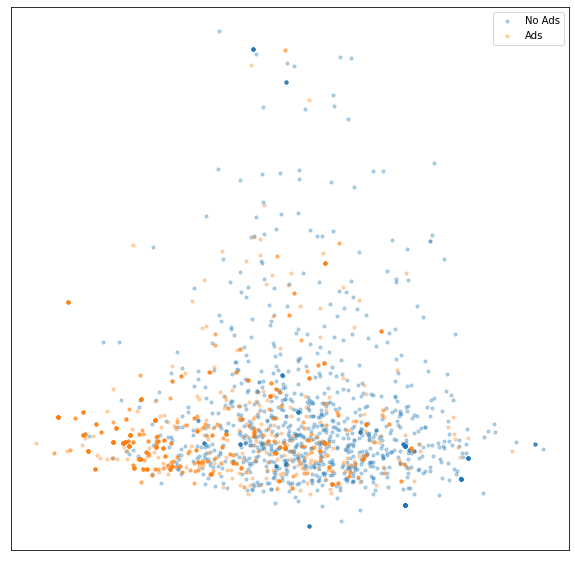

In [311]:
pl.figure(figsize=(10,10))
pl.scatter(pca_no_ads[:,0],pca_no_ads[:,1],s=10,alpha=0.3,label='No Ads')
pl.scatter(pca_ads[:,0],pca_ads[:,1],s=10,alpha=0.3,label='Ads')
pl.legend()
pl.xticks([])
pl.yticks([])